# Exploring the Bias-Variance Tradeoff

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# allow plots to appear in the notebook
%matplotlib inline

## Brain and body weight

This is a [dataset](http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt) of the average weight of the body and the brain for 62 mammal species. Let's read it into pandas and take a quick look:

In [64]:
df = pd.read_table('http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt', sep='\s+', skiprows=33, names=['id','brain','body'], index_col='id')
df.head()

,brain,body
id,,
1,3.385,44.5
2,0.480,15.5
3,1.350,8.1
4,465.000,423.0
5,36.330,119.5


In [65]:
df.describe()

,brain,body
count,62.000000,62.000000
mean,198.789984,283.134194
std,899.158011,930.278942
min,0.005000,0.140000
25%,0.600000,4.250000
50%,3.342500,17.250000
75%,48.202500,166.000000
max,6654.000000,5712.000000


We're going to focus on a smaller subset in which the body weight is less than 200:

In [66]:
# only keep rows in which the body weight is less than 200
df = df[df.body < 200]
df.shape

(51, 2)

We're actually going to pretend that there are only 51 mammal species in existence. In other words, we are pretending that this is the entire dataset of brain and body weights for **every known mammal species**.

Let's create a scatterplot (using [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)) to visualize the relationship between brain and body weight:

(-10, 250)

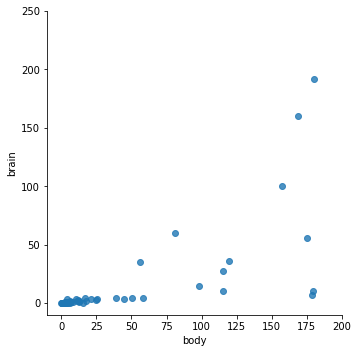

In [67]:
sns.lmplot(x='body', y='brain', data=df, ci=None, fit_reg=False)
plt.xlim(-10, 200)
plt.ylim(-10, 250)

There appears to be a relationship between brain and body weight for mammals.

## Making a prediction

Now let's pretend that a **new mammal species** is discovered. We measure the body weight of every member of this species that we can find, and calculate an **average body weight of 100**. We want to **predict the average brain weight** of this species (rather than measuring it directly). How might we do this?

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lr = LinearRegression()

In [72]:
#?lr.fit

In [73]:
x_train = df.body
y_train = df.brain

type(x_train)

pandas.core.series.Series

In [74]:
# The LinearRegression() function expects inputs as numpy arrays, instead of Pandas data frame. 
# so do a convert a quick convert and reshape:
x_train = df.body.as_matrix(columns=None).reshape(-1, 1)
y_train = df.brain.as_matrix(columns=None).reshape(-1, 1)

type(x_train)

numpy.ndarray

In [75]:
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
#?lr.score

In [80]:
# The coefficients
print('Coefficients: \t', lr.coef_)
print('Intercept: \t', lr.intercept_)

Coefficients: 	 [[0.4569348]]
Intercept: 	 [-3.63350071]


In [81]:
# Predicted values:
y_pred = lr.predict(x_train)

In [82]:
MSE1 = mean_squared_error(y_train, y_pred)
MSE1

712.8433296657508

In [83]:
R_squared1 = r2_score(y_train, y_pred)
R_squared1

0.4922592552266686

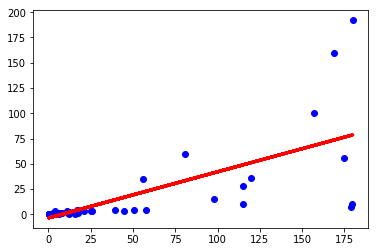

In [89]:
# Plot outputs
plt.scatter(x_train, y_train,  color='blue')
plt.plot(x_train, y_pred, color='red', linewidth=3)

plt.show()

In [87]:
# Let's see how our estimate for body = 100 works out:
# y = mx + b
m = lr.coef_
b = lr.intercept_
x = 100
y = m*x + b
y

array([[42.0599792]])

In [90]:
# Hence, we expect a brain of approx. 42.

We drew a straight line that appears to best capture the relationship between brain and body weight. So, we might predict that our new species has a brain weight of about 42, since that's the approximate y value when x=100.

In [68]:
# create a fitted model in one line
import statsmodels.formula.api as smf
lm = smf.ols(formula='brain ~ body', data=df).fit()

# print the coefficients!
lm.params

Intercept   -3.633501
body         0.456935
dtype: float64

In [69]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  brain   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     47.51
Date:                Mon, 12 Mar 2018   Prob (F-statistic):           9.74e-09
Time:                        08:04:42   Log-Likelihood:                -239.88
No. Observations:                  51   AIC:                             483.8
Df Residuals:                      49   BIC:                             487.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6335      4.676     -0.777      0.441     -13.031       5.764
body           0.4569      0.066      6.892      0.000       0.324       0.590
==============================================================================
Omnibus:                       31.781   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.711
Skew:                           1.410   Prob(JB):                     1.25e-30
Kurtosis:                      10.540   Cond. No.                         86.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Making a prediction from a sample

Earlier, I said that this dataset contained every known mammal species. That's very convenient, but **in the real world, all you ever have is a sample of data**. A more realistic situation would be to only have brain and body weights for (let's say) half of the 51 known mammals.

When that new mammal species (with a body weight of 100) is discovered, we still want to make an accurate prediction for the brain weight, but this task might be more difficult since we don't have all of the data that we would ideally like to have.

Let's simulate this situation by assigning each of the 51 rows to **either sample 1 or sample 2**:

In [92]:
# set a random seed for reproducibility
np.random.seed(12345)

# randomly assign every row to either sample 1 or sample 2
df['sample'] = np.random.randint(1, 3, len(df))
df.head()

,brain,body,sample
id,,,
1,3.385,44.5,1
2,0.480,15.5,2
3,1.350,8.1,2
5,36.330,119.5,2
6,27.660,115.0,1


We can now tell Seaborn to create two plots, in which the left plot only uses the data from **sample 1** and the right plot only uses the data from **sample 2**:

(-10, 250)

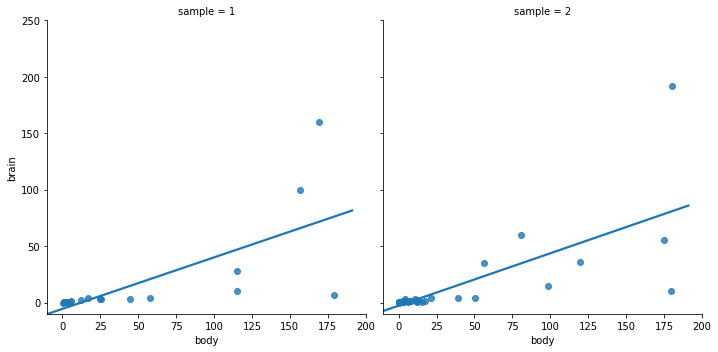

In [93]:
# col='sample' subsets the data by sample and creates two separate plots
sns.lmplot(x='body', y='brain', data=df, ci=None, col='sample')
plt.xlim(-10, 200)
plt.ylim(-10, 250)

The line looks pretty similar between the two plots, despite the fact that they used separate samples of data. In both cases, we would predict a brain weight of about 46.

It's easier to see the degree of similarity by placing them on the same plot:

(-10, 250)

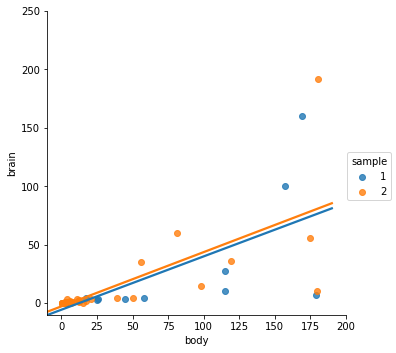

In [94]:
# hue='sample' subsets the data by sample and creates a single plot
sns.lmplot(x='body', y='brain', data=df, ci=None, hue='sample')
plt.xlim(-10, 200)
plt.ylim(-10, 250)

- It's **high bias** because the individual models (of the same model type) don't represent the sample data very well!
- It's **low variance** because the individual models (of the same model type) are similar, despite having different samples. (For a body weight of 100, the brain weight prediction is around 45 for either model)

## Let's try something completely different

What would a low bias, high variance model look like? Let's try polynomial regression, with an eighth order polynomial:

(-10, 250)

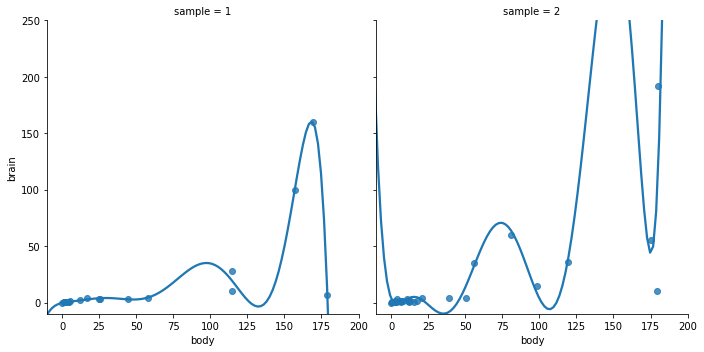

In [95]:
sns.lmplot(x='body', y='brain', data=df, ci=None, col='sample', order=8)
plt.xlim(-10, 200)
plt.ylim(-10, 250)

- It's **low bias** because the individual models (of the same model type) match the sample data quite well!
- It's **high variance** because the individual models (of the same model type) are widely different depending upon which points happen to be in the sample. (For a body weight of 100, the brain weight prediction would either be 40 or 0, depending upon which data happened to be in the sample.)

## Can we find a middle ground?

Perhaps we can create a model that has **less bias than the linear model**, and **less variance than the eighth order polynomial**?

Let's try a second order polynomial instead:

(-10, 250)

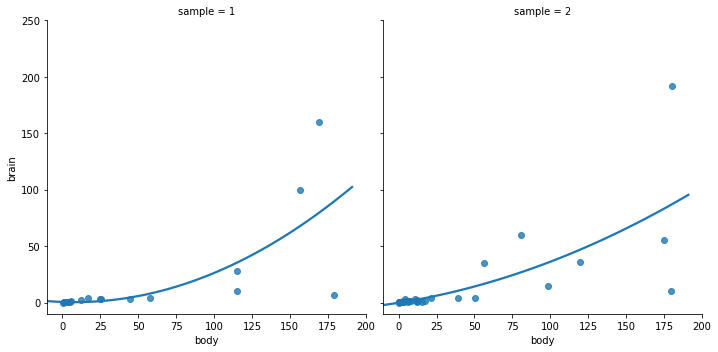

In [97]:
sns.lmplot(x='body', y='brain', data=df, ci=None, col='sample', order=2)
plt.xlim(-10, 200)
plt.ylim(-10, 250)

This seems better. In both the left and right plots, **it fits the data pretty well, but not too well**.

This is the essence of the **bias-variance tradeoff**: finding a model that appropriately balances bias and variance, and thus will generalize to new data (known as "out of sample" data).